In [126]:
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [127]:
# seed 42 to make sure all runs produce the same result
tqdm.pandas()
pl.seed_everything(42)

Global seed set to 42


42

In [128]:
df = pd.read_csv("test.csv", parse_dates=['TimeStamp'])

In [129]:
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)
    for i in tqdm(range(data_size - sequence_length)):
        sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence,label))

    return sequences

In [130]:
batch_names = list(df.Batch.unique())
for batch in tqdm(batch_names):
    list_of_indexes = np.where(df['Batch'] == batch)
    indx_to_put_zero = list_of_indexes[0][0]
    df.loc[indx_to_put_zero,'PA-MÎ¨ [Main Fermentor]'] = float(0)

df['PA-MÎ¨ [Main Fermentor]'] = df['PA-MÎ¨ [Main Fermentor]'].interpolate()
df


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


,Batch,TimeStamp,Main Fermentor's Unit,Main Fermentor's Phase,Main Fermentor's Hours,pH-M [Main Fermentor],Temperature-M [Main Fermentor],AirFlow-M [Main Fermentor],DO-M [Main Fermentor],AgitatorSpeed-M [Main Fermentor],PA-MÎ¨ [Main Fermentor]
0,PBX0086,2021-08-09 18:29:00,30M-MainF (FFN),Fermentation,0.0000,6.541058,38.280506,30.208164,107.002650,49.180222,0.000000
1,PBX0086,2021-08-09 18:59:00,30M-MainF (FFN),Fermentation,0.5000,6.547292,38.348591,34.483845,130.000000,49.059280,0.124375
2,PBX0086,2021-08-09 19:29:00,30M-MainF (FFN),Fermentation,1.0000,6.560985,38.206680,37.933174,103.047910,49.123219,0.248750
3,PBX0086,2021-08-09 19:59:00,30M-MainF (FFN),Fermentation,1.5000,6.772844,38.149670,43.399303,99.333191,49.059280,0.373125
4,PBX0086,2021-08-09 20:29:00,30M-MainF (FFN),Fermentation,2.0000,6.967603,38.126041,48.416733,88.852539,49.178154,0.497500
...,...,...,...,...,...,...,...,...,...,...,...
237,PBX0086,2021-08-14 16:59:00,30M-MainF (FFN),Fermentation,118.5000,7.236203,30.235752,59.098087,19.362829,87.520332,26.054838
238,PBX0086,2021-08-14 17:29:00,30M-MainF (FFN),Fermentation,119.0000,7.226877,30.235752,58.748810,19.703136,84.560921,26.116128
239,PBX0086,2021-08-14 17:59:00,30M-MainF (FFN),Fermentation,119.5000,7.228476,30.235752,58.126873,18.815622,88.023735,26.177418
240,PBX0086,2021-08-14 18:29:00,30M-MainF (FFN),Fermentation,120.0000,7.222972,30.402494,58.362244,14.078028,86.560051,26.238709


In [131]:
rows = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict(
        day_of_week = row.TimeStamp.dayofweek,
        day_of_month = row.TimeStamp.day, 
        week_of_year = row.TimeStamp.week,
        month = row.TimeStamp.month,
        ph = row['pH-M [Main Fermentor]'],
        temperature = row['Temperature-M [Main Fermentor]'],
        airflow = row['AirFlow-M [Main Fermentor]'],
        dissolved_oxygen = row['DO-M [Main Fermentor]'],
        agitator = row['AgitatorSpeed-M [Main Fermentor]'],
        enzyme_activity = row['PA-MÎ¨ [Main Fermentor]']
    )

    rows.append(row_data)

features_df = pd.DataFrame(rows)

100%|██████████| 242/242 [00:00<00:00, 6722.49it/s]


In [132]:
features_df.head()

,day_of_week,day_of_month,week_of_year,month,ph,temperature,airflow,dissolved_oxygen,agitator,enzyme_activity
0,0,9,32,8,6.541058,38.280506,30.208164,107.002650,49.180222,0.000000
1,0,9,32,8,6.547292,38.348591,34.483845,130.000000,49.059280,0.124375
2,0,9,32,8,6.560985,38.206680,37.933174,103.047910,49.123219,0.248750
3,0,9,32,8,6.772844,38.149670,43.399303,99.333191,49.059280,0.373125
4,0,9,32,8,6.967603,38.126041,48.416733,88.852539,49.178154,0.497500


In [133]:
training_size = int(len(features_df) * 0.9)
training_size

train_df , test_df = features_df[:training_size], features_df[training_size+1:]
train_df.shape, test_df.shape

((217, 10), (24, 10))

In [134]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [135]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns=train_df.columns
)
train_df.head()

,day_of_week,day_of_month,week_of_year,month,ph,temperature,airflow,dissolved_oxygen,agitator,enzyme_activity
0,-1.0,-1.0,-1.0,-1.0,-1.000000,0.959430,-1.000000,0.623850,-0.995025,-1.000000
1,-1.0,-1.0,-1.0,-1.0,-0.987945,0.975258,-0.796076,1.000000,-1.000000,-0.989957
2,-1.0,-1.0,-1.0,-1.0,-0.961469,0.942268,-0.631564,0.559166,-0.997370,-0.979913
3,-1.0,-1.0,-1.0,-1.0,-0.551819,0.929015,-0.370863,0.498407,-1.000000,-0.969870
4,-1.0,-1.0,-1.0,-1.0,-0.175235,0.923523,-0.131562,0.326983,-0.995110,-0.959827


In [136]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns=test_df.columns
)

test_df.head()

,day_of_week,day_of_month,week_of_year,month,ph,temperature,airflow,dissolved_oxygen,agitator,enzyme_activity
218,1.0,1.0,-1.0,-1.0,0.312719,-0.903508,0.390056,-0.753586,0.499426,1.009898
219,1.0,1.0,-1.0,-1.0,0.327997,-0.908999,0.453964,-0.801484,0.469596,1.014848
220,1.0,1.0,-1.0,-1.0,0.302991,-0.906911,0.431983,-0.737984,0.545925,1.019797
221,1.0,1.0,-1.0,-1.0,0.334062,-0.901419,0.372585,-0.702471,0.579859,1.024746
222,1.0,1.0,-1.0,-1.0,0.315992,-0.899527,0.381562,-0.802739,0.497066,1.029695


In [137]:
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)
    for i in tqdm(range(data_size - sequence_length)):
        sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence,label))

    return sequences

In [138]:
SEQUENCE_LENGTH = 10

train_sequences = create_sequences(train_df, 'enzyme_activity', SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df, 'enzyme_activity', SEQUENCE_LENGTH)

100%|██████████| 14/14 [00:00<00:00, 14001.01it/s]


In [139]:
class Fermentation_dataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

In [140]:
class FermentaionDataModule(pl.LightningDataModule):

    def __init__(self, train_sequences, test_sequences, batch_size = 8):
        super().__init__()
        self.train_sequence = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = Fermentation_dataset(self.train_sequence)
        self.test_dataset = Fermentation_dataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=0
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )   

In [141]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = FermentaionDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

for i in data_module.train_dataloader():
    print(i['sequence'].shape)
    print(i['label'].shape)
    break

torch.Size([16, 10, 10])
torch.Size([16])


In [142]:
class EnzymePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True, 
            num_layers = n_layers,
            dropout = 0.2
        )

        self.regressor = nn.Linear(n_hidden, 1)


    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

In [143]:
class EnzymePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()

        self.model = EnzymePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0

        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("validation_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [144]:
print(train_df.shape[1])
model = EnzymePredictor(n_features=train_df.shape[1])

10


In [145]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename='best-checkpoint',
    save_top_k= 1,
    verbose=True,
    monitor='validation_loss',
    mode = 'min'
)

logger = TensorBoardLogger('lightning_logs', name='btc-price')

early_stopping_callback = EarlyStopping(monitor='validation_loss', patience=20)


trainer = pl.Trainer(
    logger = logger,
    callbacks=[checkpoint_callback],
    max_epochs= N_EPOCHS,
    enable_progress_bar=True,
    num_sanity_val_steps=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [146]:
trainer.fit(model, data_module)

c:\Users\HRUT\AppData\Local\anaconda3\envs\forecasting\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory C:\Users\HRUT\OneDrive - Novozymes A S\Desktop\mtf\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | EnzymePredictionModel | 203 K 
1 | criterion | MSELoss               | 0     
----------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.816     Total estimated model params size (MB)


c:\Users\HRUT\AppData\Local\anaconda3\envs\forecasting\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\HRUT\AppData\Local\anaconda3\envs\forecasting\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\HRUT\AppData\Local\anaconda3\envs\forecasting\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of trainin

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 38.98it/s, v_num=13, train_loss=1.150, validation_loss=1.450]

Epoch 0, global step 13: 'validation_loss' reached 1.44566 (best 1.44566), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 36.31it/s, v_num=13, train_loss=1.080, validation_loss=1.360] 

Epoch 1, global step 26: 'validation_loss' reached 1.36183 (best 1.36183), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 36.73it/s, v_num=13, train_loss=1.010, validation_loss=1.280] 

Epoch 2, global step 39: 'validation_loss' reached 1.27507 (best 1.27507), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 38.64it/s, v_num=13, train_loss=0.925, validation_loss=1.180] 

Epoch 3, global step 52: 'validation_loss' reached 1.18174 (best 1.18174), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 39.37it/s, v_num=13, train_loss=0.840, validation_loss=1.070] 

Epoch 4, global step 65: 'validation_loss' reached 1.07343 (best 1.07343), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 40.40it/s, v_num=13, train_loss=0.733, validation_loss=0.940] 

Epoch 5, global step 78: 'validation_loss' reached 0.93977 (best 0.93977), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 40.39it/s, v_num=13, train_loss=0.601, validation_loss=0.768] 

Epoch 6, global step 91: 'validation_loss' reached 0.76821 (best 0.76821), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 39.49it/s, v_num=13, train_loss=0.437, validation_loss=0.550] 

Epoch 7, global step 104: 'validation_loss' reached 0.55011 (best 0.55011), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 33.58it/s, v_num=13, train_loss=0.249, validation_loss=0.303]  

Epoch 8, global step 117: 'validation_loss' reached 0.30278 (best 0.30278), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 48.31it/s, v_num=13, train_loss=0.0875, validation_loss=0.102]

Epoch 9, global step 130: 'validation_loss' reached 0.10206 (best 0.10206), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v10.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 44.06it/s, v_num=13, train_loss=0.0875, validation_loss=0.102]


In [147]:
trained_model = EnzymePredictor.load_from_checkpoint("checkpoints/best-checkpoint.ckpt", n_features= train_df.shape[1] )

trained_model.freeze()

In [148]:
test_dataset = Fermentation_dataset(test_sequences)
predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())


100%|██████████| 14/14 [00:00<00:00, 1076.84it/s]


In [149]:
len(predictions), len(test_df)

(14, 24)

In [150]:
len(test_df) - SEQUENCE_LENGTH

14

In [151]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,ph,temperature,airflow,dissolved_oxygen,agitator,enzyme_activity
218,1.0,1.0,-1.0,-1.0,0.312719,-0.903508,0.390056,-0.753586,0.499426,1.009898
219,1.0,1.0,-1.0,-1.0,0.327997,-0.908999,0.453964,-0.801484,0.469596,1.014848
220,1.0,1.0,-1.0,-1.0,0.302991,-0.906911,0.431983,-0.737984,0.545925,1.019797
221,1.0,1.0,-1.0,-1.0,0.334062,-0.901419,0.372585,-0.702471,0.579859,1.024746
222,1.0,1.0,-1.0,-1.0,0.315992,-0.899527,0.381562,-0.802739,0.497066,1.029695


In [152]:
descaler = MinMaxScaler()
descaler.min_ , descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

In [153]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [154]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

In [155]:
test_data = df[training_size + 1 :]
len(test_data), len(test_df)

(24, 24)

In [156]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
len(test_sequences_data), len(test_sequences)

(14, 14)

In [157]:
test_sequences_data

,Batch,TimeStamp,Main Fermentor's Unit,Main Fermentor's Phase,Main Fermentor's Hours,pH-M [Main Fermentor],Temperature-M [Main Fermentor],AirFlow-M [Main Fermentor],DO-M [Main Fermentor],AgitatorSpeed-M [Main Fermentor],PA-MÎ¨ [Main Fermentor]
228,PBX0086,2021-08-14 12:29:00,30M-MainF (FFN),Fermentation,114.0000,7.240450,30.270784,59.303455,21.970646,86.903122,25.503225
229,PBX0086,2021-08-14 12:59:00,30M-MainF (FFN),Fermentation,114.5000,7.223163,30.247158,56.693062,18.484898,85.706749,25.564516
230,PBX0086,2021-08-14 13:29:00,30M-MainF (FFN),Fermentation,115.0000,7.222640,30.235752,58.993076,17.348991,86.497513,25.625806
231,PBX0086,2021-08-14 13:59:00,30M-MainF (FFN),Fermentation,115.5000,7.236052,30.235752,58.907616,25.878056,84.485840,25.687096
232,PBX0086,2021-08-14 14:29:00,30M-MainF (FFN),Fermentation,116.0000,7.229375,30.247158,59.041195,24.093956,87.275871,25.748386
233,PBX0086,2021-08-14 14:59:00,30M-MainF (FFN),Fermentation,116.5000,7.240545,30.270784,59.254147,16.853601,86.126419,25.809677
234,PBX0086,2021-08-14 15:29:00,30M-MainF (FFN),Fermentation,117.0000,7.228661,30.273228,59.251396,24.040520,86.620003,25.870967
235,PBX0086,2021-08-14 15:59:00,30M-MainF (FFN),Fermentation,117.5000,7.210981,30.249609,58.634285,25.157997,86.648949,25.932257
236,PBX0086,2021-08-14 16:29:00,30M-MainF (FFN),Fermentation,118.0000,7.223163,30.235752,59.800526,23.143524,86.342979,25.993548
237,PBX0086,2021-08-14 16:59:00,30M-MainF (FFN),Fermentation,118.5000,7.236203,30.235752,59.098087,19.362829,87.520332,26.054838


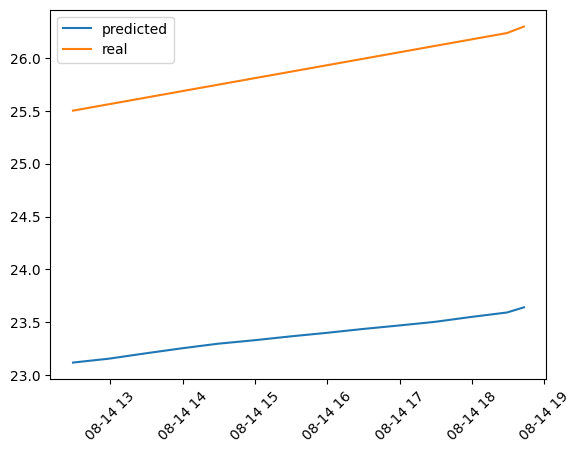

In [158]:
import matplotlib

dates = matplotlib.dates.date2num(test_sequences_data.TimeStamp.tolist())
plt.plot_date(dates, predictions_descaled, "-", label="predicted")
plt.plot_date(dates, labels_descaled, "-", label="real")
plt.xticks(rotation=45)
plt.legend()